In [24]:
import pandas as pd
import numpy as np
import nltk
import jieba
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to C:\Users\Pro-
[nltk_data]     Tech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Basic text cleaning and tokenization with Jieba
def preprocess_text(text):
    text = str(text)
    # Tokenization with Jieba
    tokens = list(jieba.cut(text))
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [5]:
# Replace NaN values with an empty string
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Apply preprocessing
df_train['tokens'] = df_train['text'].apply(preprocess_text)
df_test['tokens'] = df_test['text'].apply(preprocess_text)

Building prefix dict from C:\Users\Pro-Tech\anaconda3\envs\tensorflow\lib\site-packages\jieba\dict.txt ...
Loading model from cache C:\Users\Pro-Tech\AppData\Local\Temp\jieba.cache
Loading model cost 1.7813835144042969 seconds.
Prefix dict has been built succesfully.


In [6]:
# Concatenate tokens for Word2Vec training
all_tokens = pd.concat([df_train['tokens'], df_test['tokens']], axis=0)

# Train a Word2Vec model or load a pre-trained model
model_w2v = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [7]:
# Function to convert tokens to vectors, using zero vector for unknown words
def tokens_to_vectors(tokens, model):
    vectors = [model.wv[word] if word in model.wv else np.zeros((model.vector_size,)) for word in tokens]
    return np.array(vectors)

In [8]:
# Convert train and test tokens to vectors
df_train['vectors'] = df_train['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))
df_test['vectors'] = df_test['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))

In [9]:
# Find the maximum sequence length to use for padding
max_seq_length = max(df_train['vectors'].apply(len).max(), df_test['vectors'].apply(len).max())

In [10]:
# Pad sequences
X_train_padded = pad_sequences(df_train['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
X_test_padded = pad_sequences(df_test['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')

In [11]:
# Convert sentiment labels to numerical values
label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
df_train['label'] = df_train['sentiment'].map(label_mapping)
y_train = df_train['label'].values

In [12]:
# Split dataset into training, validation, and test sets
X_train_padded, X_temp, y_train, y_temp = train_test_split(X_train_padded, y_train, test_size=0.4, random_state=42)
X_val_padded, X_test_padded, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
from tensorflow.keras.layers import MultiHeadAttention

In [14]:
embedding_dim = model_w2v.vector_size
input_layer = Input(shape=(max_seq_length, embedding_dim))
attention_out = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, value_dim=embedding_dim)(query=input_layer, key=input_layer, value=input_layer)

# TextCNN
conv1 = Conv1D(filters=100, kernel_size=3, activation='relu')(attention_out)
conv2 = Conv1D(filters=100, kernel_size=4, activation='relu')(attention_out)
conv3 = Conv1D(filters=100, kernel_size=5, activation='relu')(attention_out)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

concatenated = Concatenate()([pool1, pool2, pool3])

# Fully connected layer
output_layer = Dense(units=3, activation='softmax')(concatenated)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history= model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=10, batch_size=64, verbose=1)

Epoch 1/10
258/258 [==============================] - 113s 437ms/step - loss: 0.9174 - accuracy: 0.5714 - val_loss: 0.9315 - val_accuracy: 0.5635
Epoch 2/10
258/258 [==============================] - 119s 460ms/step - loss: 0.9141 - accuracy: 0.5738 - val_loss: 0.9459 - val_accuracy: 0.5595
Epoch 3/10
258/258 [==============================] - 115s 447ms/step - loss: 0.8999 - accuracy: 0.5892 - val_loss: 0.9047 - val_accuracy: 0.5819
Epoch 4/10
258/258 [==============================] - 121s 469ms/step - loss: 0.8952 - accuracy: 0.5844 - val_loss: 0.9069 - val_accuracy: 0.5744
Epoch 5/10
258/258 [==============================] - 117s 455ms/step - loss: 0.8902 - accuracy: 0.5905 - val_loss: 0.9102 - val_accuracy: 0.5751
Epoch 6/10
258/258 [==============================] - 114s 443ms/step - loss: 0.8877 - accuracy: 0.5953 - val_loss: 0.8984 - val_accuracy: 0.5910
Epoch 7/10
258/258 [==============================] - 113s 438ms/step - loss: 0.8831 - accuracy: 0.5944 - val_loss: 0.9178 -

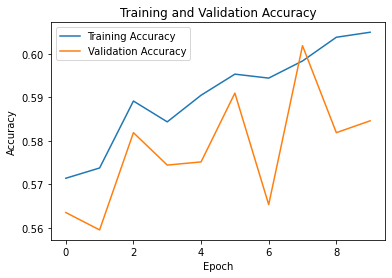

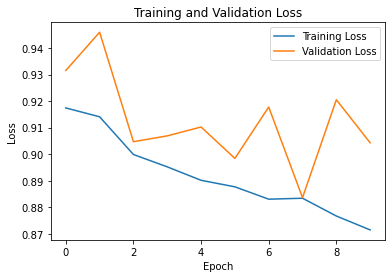

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<AxesSubplot: >

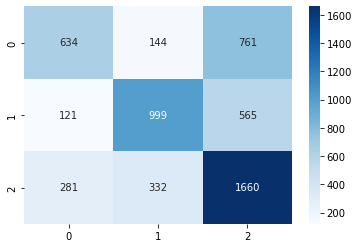

In [20]:
# Evaluate the model
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)

# Metrics and Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

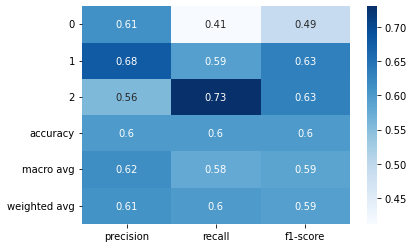

In [21]:
clf_report=classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="Blues")
plt.show()

Overall ROC-AUC Score: 0.7715584202486506


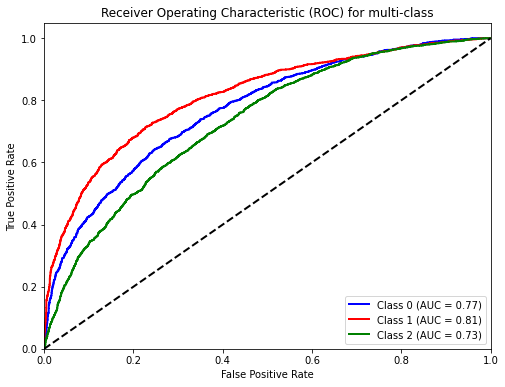

In [32]:
from sklearn.preprocessing import LabelBinarizer

# Convert y_test to one-hot encoded format if it's not already
if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

# Calculate the ROC AUC Score
y_prob = model.predict(X_test_padded)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"Overall ROC-AUC Score: {roc_auc_ovr}")

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1] 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for multi-class')
plt.legend(loc="lower right")
plt.show()